In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim            #提供optimizer 

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

torch.set_printoptions(linewidth=120)            #display options for output

In [2]:
class Network(nn.Module):  #line 1
    def __init__(self):
        super(Network, self).__init__()  #line 3       #继承了nn.Module的__init__()
    #共有五个layers作为attributes
        #下面是两个convolutional layers,图片的输入是1*28*28
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)   #第一个layer的in-channels取决于数据，fashionMNIST是灰度的，dim为1
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)  #中间每一个layer的输出都是下一个layer的输入
        
        #下面是三个linear layers，其中最后一个linear layer是output。linear layer 又称为fully connected(fc) layer/dense layer
        self.fc1 = nn.Linear(in_features=12 * 4 * 4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10)    #最后一个layer的out_features取决于数据，fashionMNIST最后有十个输出
        
    def forward(self, t):                    #一直在对一个输入的数据t做操作
        # (1) input layer
        t = t                                 
        # (2) hidden conv layer                          
        t = F.max_pool2d(F.relu(self.conv1(t)), kernel_size=2, stride=2)   
        # (3) hidden conv layer
        t = F.max_pool2d(F.relu(self.conv2(t)), kernel_size=2, stride=2)
        # (4) hidden linear layer
        t = F.relu(self.fc1(t.reshape(-1, 12 * 4 * 4)))
        # (5) hidden linear layer
        t = F.relu(self.fc2(t))
        # (6) output layer
        t = self.out(t)
        #t = F.softmax(t, dim=1)
        return t

In [3]:
train_set = torchvision.datasets.FashionMNIST(
    root='./data/FashionMNIST'                      #1/ 从这里开始extract，其中这一行是希望data储存到哪里
    ,train=True                                              #表示data是训练集
    ,download=True                                           #表示要下载数据，如果数据
    ,transform=transforms.Compose([                 #2/ transform
        transforms.ToTensor()                                #表示要将数据变成tensor
    ])
)

BATCH_SIZE=10000

train_loader = torch.utils.data.DataLoader(  #3/ load，load给我们access to data，也给我们querying abilities，如选定batch_size和shuffle
    train_set                                                #表示提取的数据集是train_set
    ,batch_size=BATCH_SIZE                                        #表示批量大小为10,默认为0
    ,shuffle=True                                            #表示打乱数据顺序
)

print(train_set)

Dataset FashionMNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ./data/FashionMNIST
    Transforms (if any): Compose(
                             ToTensor()
                         )
    Target Transforms (if any): None


In [4]:
def pred_rate(preds,labels):
    return preds.eq(labels).sum().item()/labels.shape[0]

In [5]:
#读取之前训练了一部分的模型，或许还可以更完善
network=torch.load('FashionMNIST.pkl')

In [6]:
#network模型用GPU还是CPU训练,这里由于之前存入的network是CPU训练并保存的，所以这里用GPU会出问题
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#多个epoch训练：
optimizer=optim.Adam(network.parameters(),lr=0.001) #需要将network的参数(包括weight)传入才能构建optimizer,并且learning rate=0.001

for epoch in range(1):
    for step,(batch_x,batch_y) in enumerate(train_loader):
        #batch_x,batch_y=batch_x.to(device),batch_y.to(device)     #如果可以，tensor放到gpu上
        out=network(batch_x)
        loss=F.cross_entropy(out,batch_y)            #F.cross_entropy函数计算loss
        
        optimizer.zero_grad()
        loss.backward()                         #使用backpropogation算法计算grad
        optimizer.step()    #表示将要用该optimizer，通过loss function的最小化来更新weights
        
        preds=out.argmax(dim=1)
        print('Epoch: ', epoch, '| Step: ', step,'| loss: ',loss.item(), '| prection rate: ',pred_rate(preds,batch_y))
        
torch.save(network,'FashionMNIST.pkl')

Epoch:  0 | Step:  0 | loss:  0.3868938088417053 | prection rate:  0.8652
Epoch:  0 | Step:  1 | loss:  0.45800071954727173 | prection rate:  0.8278
Epoch:  0 | Step:  2 | loss:  0.41075757145881653 | prection rate:  0.8466
Epoch:  0 | Step:  3 | loss:  0.3970241844654083 | prection rate:  0.8552
Epoch:  0 | Step:  4 | loss:  0.38179293274879456 | prection rate:  0.8648
Epoch:  0 | Step:  5 | loss:  0.4112284779548645 | prection rate:  0.8483


c:\users\chenq\anaconda3\envs\py37\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Network. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [7]:
#用模型预测数据
test_set = torchvision.datasets.FashionMNIST(
    root='./data/FashionMNIST',
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor()
    ])
)
print(test_set)

test_loader=torch.utils.data.DataLoader(test_set)

sum_correct=0
for test_x,test_y in test_loader:               #test_loader里面要一个一个数据取，用for
    test_x.test_y=test_x.to(device),test_y.to(device)
    out=network(test_x)
    pred=out.argmax(dim=1)
    sum_correct+=(pred.data.numpy().item()==test_y.data.numpy().item())
my_rate=sum_correct/len(test_set)
print('By using the test set,the prediction rate is: ',my_rate)

Dataset FashionMNIST
    Number of datapoints: 10000
    Split: test
    Root Location: ./data/FashionMNIST
    Transforms (if any): Compose(
                             ToTensor()
                         )
    Target Transforms (if any): None
By using the test set,the prediction rate is:  0.8478


As far as I can see, these photos are respectively: 
       pred_label  true_label    pred_name    true_name
Index                                                  
0               5           5       Sandal       Sandal
1               3           3        Dress        Dress
2               7           7      Sneaker      Sneaker
3               2           6     Pullover        Shirt
4               6           2        Shirt     Pullover
5               9           9   Ankle boot   Ankle boot
6               6           2        Shirt     Pullover
7               9           9   Ankle boot   Ankle boot
8               8           4          Bag         Coat
9               8           8          Bag          Bag
10              4           2         Coat     Pullover
11              0           6  T-shirt/top        Shirt
12              5           5       Sandal       Sandal
13              5           5       Sandal       Sandal
14              0           0  T-shirt/top  T-shirt

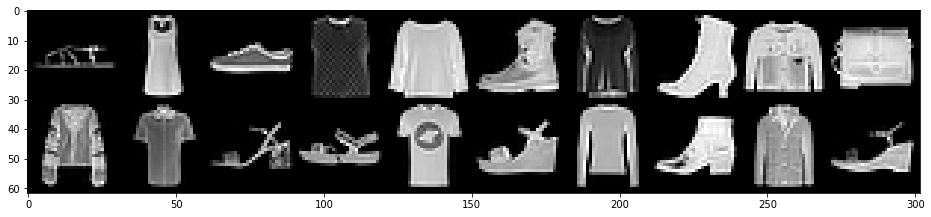

In [8]:
#用模型预测数据,抽样几个
test_loader = torch.utils.data.DataLoader(  #3/ load，load给我们access to data，也给我们querying abilities，如选定batch_size和shuffle
    train_set                                                #表示提取的数据集是train_set
    ,batch_size=20                                           #表示批量大小为10,默认为0
    ,shuffle=True                                            #表示打乱数据顺序
)

batch=next(iter(test_loader))
images,labels=batch
grid=torchvision.utils.make_grid(images,nrow=10)
plt.figure(figsize=(16,10))
plt.imshow(np.transpose(grid,(1,2,0)))       #对grid作转置，之前是3*32*302的，这种高级转置方法变成了32*302*3，把channel那一维度放到最后


out=network(images)
preds=out.argmax(dim=1)
my_rate=pred_rate(preds,labels)
print("As far as I can see, these photos are respectively: ")

fashion_dict={0:'T-shirt/top',1:'Trouser',2:'Pullover',3:'Dress',4:'Coat',5:'Sandal',6:'Shirt',7:'Sneaker',8:'Bag',9:'Ankle boot'}
#制作dataframe
pred_names=[]
true_names=[]
[pred_names.append(fashion_dict[preds.data.numpy()[i]]) for i in range(preds.data.numpy().shape[0])]
[true_names.append(fashion_dict[labels.data.numpy()[i]]) for i in range(labels.data.numpy().shape[0])]

pred_labels=pd.Series(preds.data.numpy())
true_labels=pd.Series(labels.data.numpy())
pred_names=pd.Series(pred_names)
true_names=pd.Series(true_names)

result={'pred_label':pred_labels,'true_label':true_labels,'pred_name':pred_names,'true_name':true_names}
result=pd.DataFrame(result)
#result.set_index('pred_label', inplace=True) 可以把index的数字去掉，把pred_label当作index
result.index.name='Index'
print(result)
print()
print("My prediction rate is: ",pred_rate(preds,labels),", bravo!!")